In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from skimage import io

In [2]:
# Understanding data - csv
# image_path = '/media/nicolas/Lenovo/Projects/UnderstandingAmazon/data'

#https://www.kaggle.com/competitions/planet-understanding-the-amazon-from-space

#inspiration from
#https://www.kaggle.com/code/robinkraft/getting-started-with-the-data-now-with-docs

In [3]:
train_data = pd.read_csv('data/train_v2.csv')

In [4]:
train_data.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
#so many individual classes
class_num = train_data['tags'].value_counts()
class_num

clear primary                                               13636
partly_cloudy primary                                        3630
cloudy                                                       2089
clear primary water                                          1850
agriculture clear primary road                               1680
                                                            ...  
agriculture clear cultivation cultivation road                  1
artisinal_mine bare_ground partly_cloudy primary road           1
agriculture clear conventional_mine primary road                1
clear conventional_mine habitation road                         1
agriculture partly_cloudy primary road conventional_mine        1
Name: tags, Length: 449, dtype: int64

In [6]:
#seems like some tags have duplicated information 
# eg -> agriculture clear cultivation cultivation road has 'cultivation' repetated.
# lets clean that out
train_data['tags_no_dups'] = train_data['tags'].str.split().apply(lambda x:' '.join(set(x)))

In [7]:
weather_labels = {'clear', 'partly_cloudy', 'haze'}

In [8]:
#removing weather labels minus 'cloudy' i want a model to that learns to classify no matter weather conditions

train_data['tags_no_weather'] = train_data['tags_no_dups'].apply(lambda x: ' '.join(set(x.split(' ')).difference(weather_labels)))

In [9]:
train_data.head()

,image_name,tags,tags_no_dups,tags_no_weather
0,train_0,haze primary,haze primary,primary
1,train_1,agriculture clear primary water,clear water agriculture primary,water agriculture primary
2,train_2,clear primary,clear primary,primary
3,train_3,clear primary,clear primary,primary
4,train_4,agriculture clear habitation primary road,primary agriculture road clear habitation,habitation agriculture road primary


In [10]:
class_num = train_data['tags_no_weather'].value_counts()
class_num

primary                                                      18737
water primary                                                 2759
agriculture primary                                           2490
agriculture road primary                                      2337
cloudy                                                        2089
                                                             ...  
bare_ground agriculture road conventional_mine habitation        1
primary cultivation bare_ground agriculture road water           1
habitation selective_logging road primary                        1
bare_ground agriculture habitation                               1
primary cultivation bare_ground selective_logging road           1
Name: tags_no_weather, Length: 253, dtype: int64

In [11]:
#count how many individual classes are in the dataset
from collections import Counter
counter = Counter()
for pic in train_data['tags_no_weather'].str.split():
    counter.update(pic)

In [12]:
individual_label = pd.DataFrame(counter.values(),counter.keys()).sort_values(by =0 , ascending = False)
individual_label.rename({0:'count'},axis = 1,inplace = True)
individual_label = individual_label.reset_index()

In [13]:
individual_label.rename({'index':'label'},axis = 1,inplace = True)

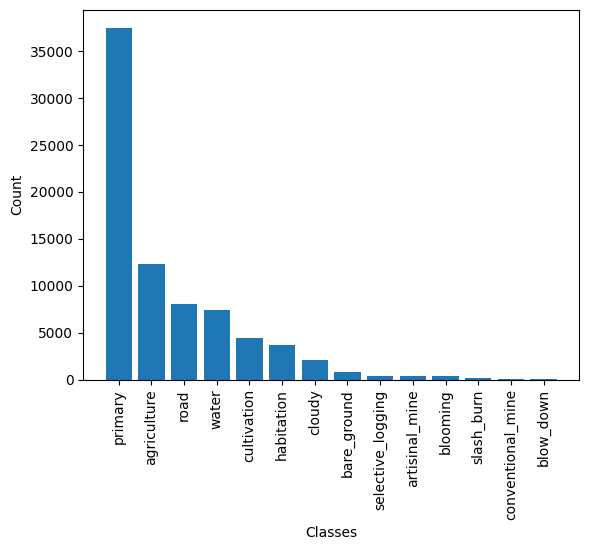

In [14]:
plt.bar(individual_label['label'],individual_label['count'])
plt.xticks(rotation = 90)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

In [15]:
individual_label

,label,count
0,primary,37513
1,agriculture,12315
2,road,8071
3,water,7411
4,cultivation,4477
5,habitation,3660
6,cloudy,2089
7,bare_ground,862
8,selective_logging,340
9,artisinal_mine,339


In [16]:
#Chips that are labeled as cloudy should have no other labels, but there might be labeling errors
#correct

In [17]:
train_data[~(train_data['tags_no_weather'].str.contains('partly_cloudy'))&
            (train_data['tags_no_weather'].str.contains('cloudy'))&
            (train_data['tags_no_weather'].str.split().apply(lambda x:len(x)) != 1)]


,image_name,tags,tags_no_dups,tags_no_weather


In [18]:
#No errors

In [19]:
#tags per image one hot
for tag in individual_label['label']:
    train_data[tag] = train_data['tags_no_weather'].apply(lambda x:1 if tag in x.split() else 0)

In [20]:
train_data.head()

,image_name,tags,tags_no_dups,tags_no_weather,primary,agriculture,road,water,cultivation,habitation,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,conventional_mine,blow_down
0,train_0,haze primary,haze primary,primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,clear water agriculture primary,water agriculture primary,1,1,0,1,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,clear primary,primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,clear primary,primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,primary agriculture road clear habitation,habitation agriculture road primary,1,1,1,0,0,1,0,0,0,0,0,0,0,0


In [21]:
#from kaggle notebook
# display correlation between labels
def heatmap_matrix(labels):
    numeric_df = train_data[individual_label['label']][labels]
    matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(matrix,cmap='Blues')
    return matrix

,primary,agriculture,road,water,cultivation,habitation,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,conventional_mine,blow_down
primary,37513,11972,7728,7001,4455,3469,0,683,340,324,332,209,94,98
agriculture,11972,12315,6034,2712,3377,2737,0,225,65,38,32,119,24,22
road,7728,6034,8071,2125,1294,2786,0,323,151,110,10,36,59,2
water,7001,2712,2125,7411,868,915,0,206,49,299,16,24,26,3
cultivation,4455,3377,1294,868,4477,895,0,89,58,18,35,126,4,8
habitation,3469,2737,2786,915,895,3660,0,163,13,29,4,41,36,3
cloudy,0,0,0,0,0,0,2089,0,0,0,0,0,0,0
bare_ground,683,225,323,206,89,163,0,862,13,40,3,10,10,4
selective_logging,340,65,151,49,58,13,0,13,340,6,7,2,0,1
artisinal_mine,324,38,110,299,18,29,0,40,6,339,0,0,4,0


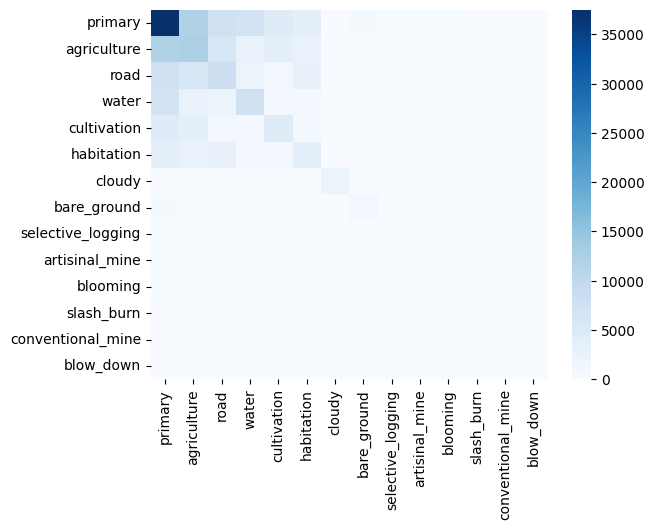

In [22]:
matrix = heatmap_matrix(individual_label['label'])
matrix

In [23]:
#which clases have less than 2000 instanaces?

rare_individual = individual_label[individual_label['count'] < 2000]

In [24]:
rare_individual

,label,count
7,bare_ground,862
8,selective_logging,340
9,artisinal_mine,339
10,blooming,332
11,slash_burn,209
12,conventional_mine,100
13,blow_down,98


# Images

In [25]:
#select images to display

In [26]:
top_10_classes = class_num[:10]
last_10_classes = class_num[-10:]

In [27]:
top_10_classes.index

Index(['primary', 'water primary', 'agriculture primary',
       'agriculture road primary', 'cloudy', 'cultivation agriculture primary',
       'habitation agriculture road primary', 'water agriculture primary',
       'water road primary', 'water agriculture road primary'],
      dtype='object')

In [28]:
#first mount disk on machine
image_path = '/media/nicolas/Lenovo/Projects/UnderstandingAmazon/data'
image_jpg_list = os.path.join(image_path,'train-jpg')
image_tiff_list = os.path.join(image_path,'train-tif-v2')

In [29]:
def random_sample(labels,ext):
    images = []
    if ext == '.jpg':
        dirname = image_jpg_list
    else:
        dirname = image_tiff_list
    
    for image in labels.index:
        image_name = train_data[train_data['tags_no_weather']== image].sample(1,random_state=1080)['image_name'].iloc[0] + ext
        img = io.imread(os.path.join(dirname,image_name))
        images.append([image_name,image,img])
    return images

In [30]:
#from kaggle notebook
#plot rgbn histogram
def plot_rgbn_histo(image):
    bgr_image = image[:,:,:3]
    rgb_image = image[:, :, [2,1,0]]
    
    b, g, r = bgr_image[:, :, 0], bgr_image[:, :, 1], bgr_image[:, :, 2]
    for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue')):
        plt.hist(slice_.ravel(), bins=100, 
                 range=[0,rgb_image.max()], 
                 label=name, color=color, histtype='step')
    plt.legend()

In [32]:
images_jpg = random_sample(top_10_classes,'.jpg')
images_tif = random_sample(top_10_classes,'.tif')

In [33]:
images_jpg_last = random_sample(last_10_classes,'.jpg')

In [34]:
images_jpg[0][1],images_tif[0][1]

('primary', 'primary')

In [35]:
sample_image_jpg = images_jpg[0][2]
sample_image_tif = images_tif[0][2]


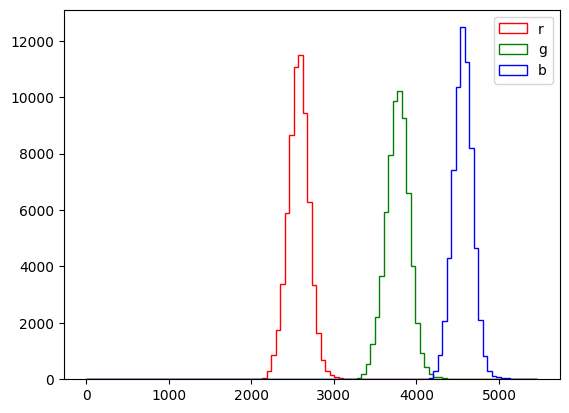

In [36]:
plot_rgbn_histo(sample_image_tif)

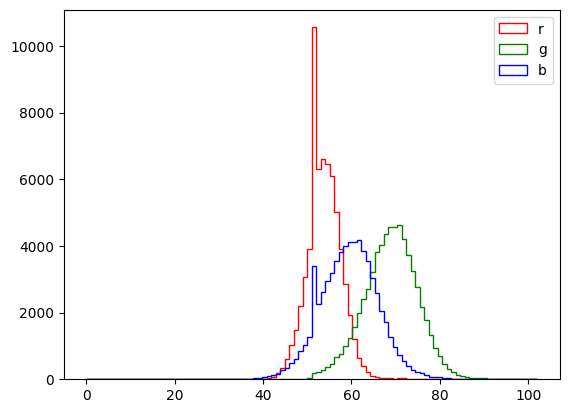

In [37]:
plot_rgbn_histo(sample_image_jpg)

In [38]:
def plot_images(images):
    fig = plt.figure(figsize=(20, 20))
    for i,img in enumerate(images):
        ax = fig.add_subplot(2, 5, i+1)
        ax.set_title(img[1],fontsize = 8)
        fig.set_figheight(8)
        fig.set_figwidth(28)
        plt.imshow(img[2])
    plt.show()

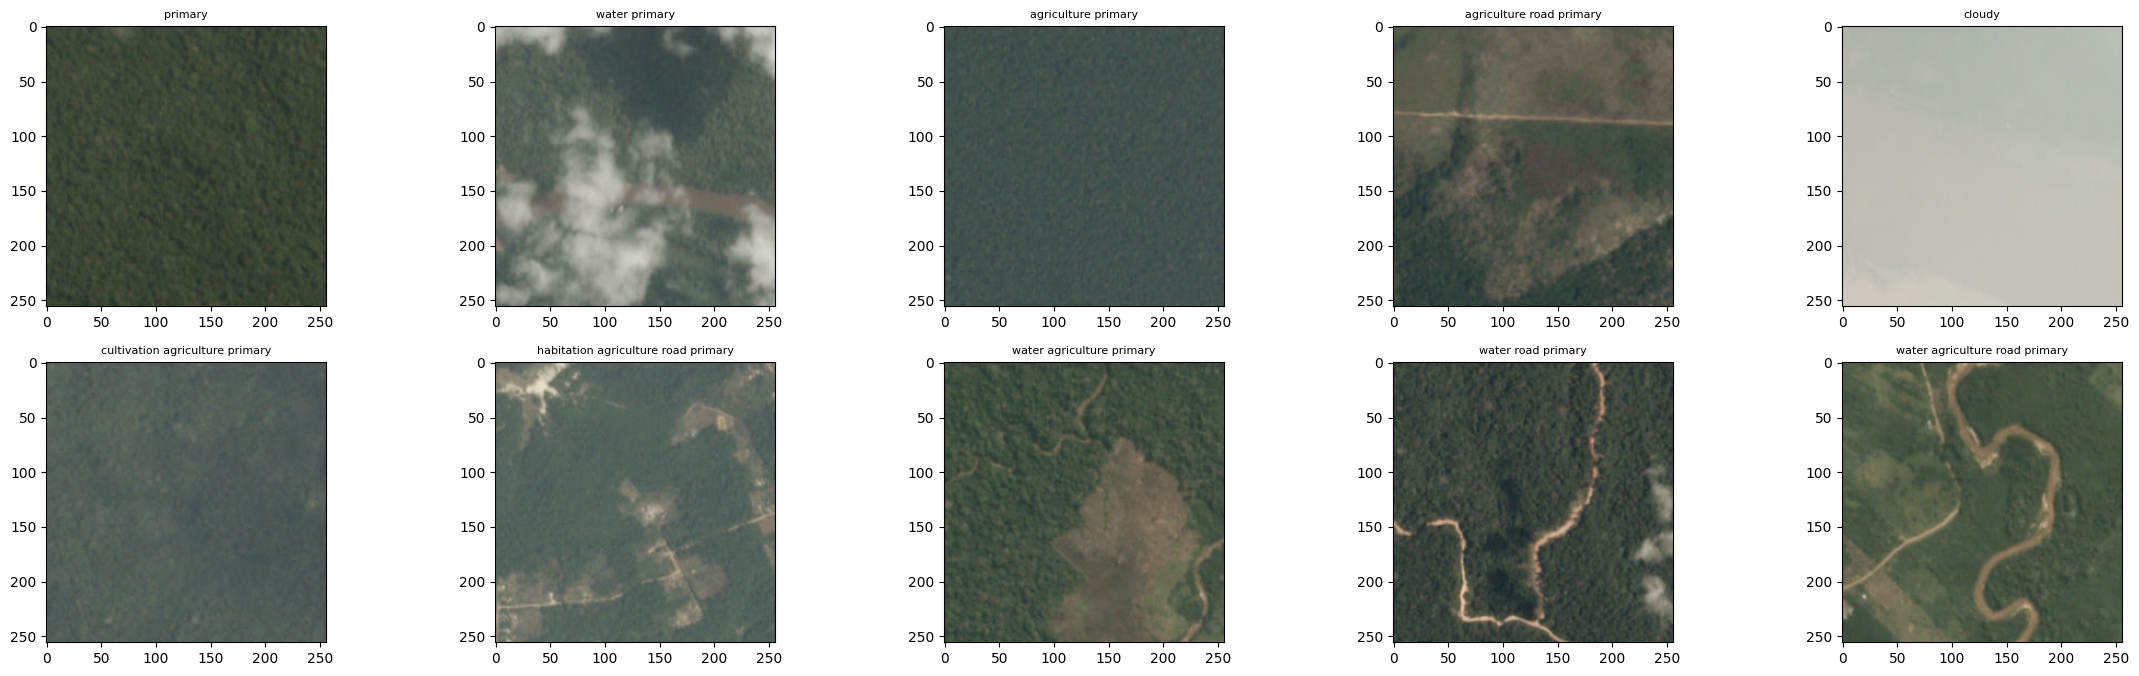

In [39]:
plot_images(images_jpg)

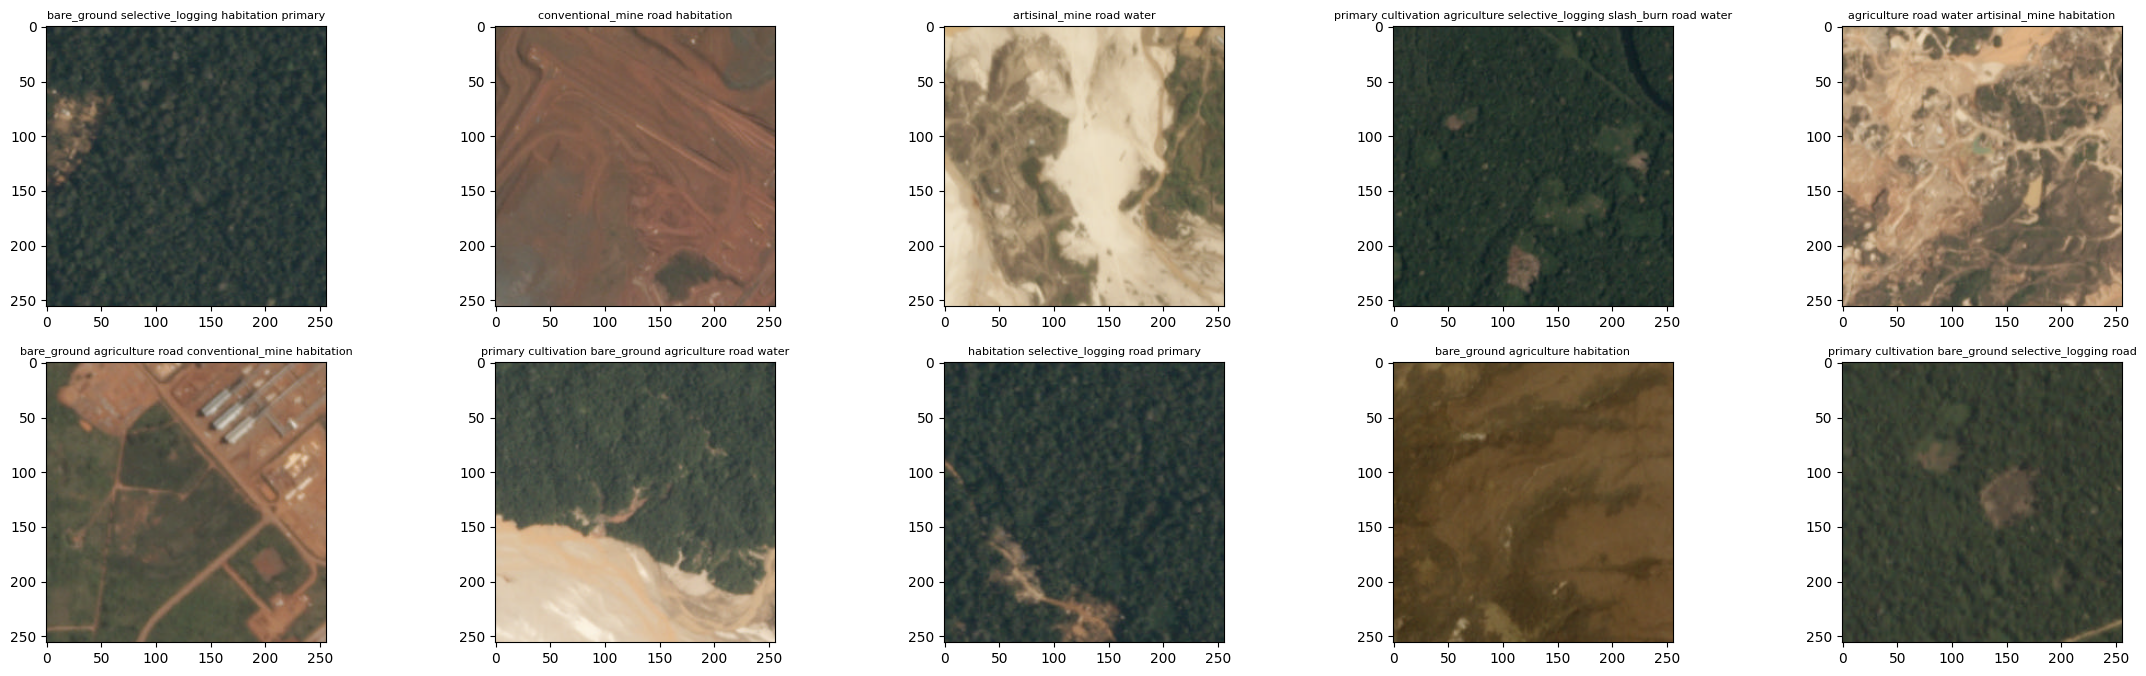

In [40]:
plot_images(images_jpg_last)

# Classes

In [41]:
matrix

,primary,agriculture,road,water,cultivation,habitation,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,conventional_mine,blow_down
primary,37513,11972,7728,7001,4455,3469,0,683,340,324,332,209,94,98
agriculture,11972,12315,6034,2712,3377,2737,0,225,65,38,32,119,24,22
road,7728,6034,8071,2125,1294,2786,0,323,151,110,10,36,59,2
water,7001,2712,2125,7411,868,915,0,206,49,299,16,24,26,3
cultivation,4455,3377,1294,868,4477,895,0,89,58,18,35,126,4,8
habitation,3469,2737,2786,915,895,3660,0,163,13,29,4,41,36,3
cloudy,0,0,0,0,0,0,2089,0,0,0,0,0,0,0
bare_ground,683,225,323,206,89,163,0,862,13,40,3,10,10,4
selective_logging,340,65,151,49,58,13,0,13,340,6,7,2,0,1
artisinal_mine,324,38,110,299,18,29,0,40,6,339,0,0,4,0


In [42]:
#data augmentation on classes that have few training examples
data_to_augment = individual_label[8:]

In [43]:
data_to_augment

,label,count
8,selective_logging,340
9,artisinal_mine,339
10,blooming,332
11,slash_burn,209
12,conventional_mine,100
13,blow_down,98


In [44]:
train_data

,image_name,tags,tags_no_dups,tags_no_weather,primary,agriculture,road,water,cultivation,habitation,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,conventional_mine,blow_down
0,train_0,haze primary,haze primary,primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,clear water agriculture primary,water agriculture primary,1,1,0,1,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,clear primary,primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,clear primary,primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,primary agriculture road clear habitation,habitation agriculture road primary,1,1,1,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40474,train_40474,clear primary,clear primary,primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0
40475,train_40475,cloudy,cloudy,cloudy,0,0,0,0,0,0,1,0,0,0,0,0,0,0
40476,train_40476,agriculture clear primary,clear agriculture primary,agriculture primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0
40477,train_40477,agriculture clear primary road,clear agriculture road primary,agriculture road primary,1,1,1,0,0,0,0,0,0,0,0,0,0,0


In [45]:
images_names = []
for idx, tag in enumerate(train_data['tags_no_weather']):
    for label in data_to_augment['label']:
        if label in tag:
            image_name = train_data['image_name'].iloc[idx]
            images_names.append([image_name,tag])

In [46]:
new_df = train_data[['image_name','tags_no_weather']]

In [47]:
new_df

,image_name,tags_no_weather
0,train_0,primary
1,train_1,water agriculture primary
2,train_2,primary
3,train_3,primary
4,train_4,habitation agriculture road primary
...,...,...
40474,train_40474,primary
40475,train_40475,cloudy
40476,train_40476,agriculture primary
40477,train_40477,agriculture road primary


In [48]:
df_augment = pd.DataFrame(images_names,columns = ['image_name','tags_no_weather'])

In [49]:
df_augment

,image_name,tags_no_weather
0,train_10,slash_burn water agriculture primary
1,train_24,conventional_mine primary
2,train_57,artisinal_mine water bare_ground primary
3,train_70,blooming primary
4,train_82,blooming primary cultivation slash_burn habita...
...,...,...
1413,train_40446,slash_burn water primary
1414,train_40453,artisinal_mine primary
1415,train_40455,conventional_mine agriculture road primary
1416,train_40457,water selective_logging road primary


# data_augmentation 

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

In [51]:
IMG_SIZE = 256

datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True) 


In [52]:
path_ = f"{image_path}/train-jpg/"

In [53]:
for f in df_augment['image_name']:
    img = load_img(f"{path_}/{f}.jpg")  
    x = img_to_array(img) 
    # Reshape the input image 
    x = x.reshape((1,) + x.shape)  
    i = 0
 
    for batch in datagen.flow(x, batch_size = 1, save_to_dir = path_, save_prefix = f"augmented_{f}" , save_format ='jpg'):
        i += 1
        if i == 2: 
            break
    

In [54]:
df_augment['image_name'].apply(lambda x:'augmented_' + x)

0          augmented_train_10
1          augmented_train_24
2          augmented_train_57
3          augmented_train_70
4          augmented_train_82
                ...          
1413    augmented_train_40446
1414    augmented_train_40453
1415    augmented_train_40455
1416    augmented_train_40457
1417    augmented_train_40465
Name: image_name, Length: 1418, dtype: object

In [55]:
# search artificial generated images

In [56]:
augmented = [img for img in os.listdir(path_) if 'augmented' in img]

In [57]:
df_augment

,image_name,tags_no_weather
0,train_10,slash_burn water agriculture primary
1,train_24,conventional_mine primary
2,train_57,artisinal_mine water bare_ground primary
3,train_70,blooming primary
4,train_82,blooming primary cultivation slash_burn habita...
...,...,...
1413,train_40446,slash_burn water primary
1414,train_40453,artisinal_mine primary
1415,train_40455,conventional_mine agriculture road primary
1416,train_40457,water selective_logging road primary


In [58]:
data_files = []
for i in augmented:
    for label, img in zip(df_augment['tags_no_weather'], df_augment['image_name']):
        if f"{img}_" in i:
            data_files.append([i,label])        
            
    
    

In [59]:
augmented = pd.DataFrame(data_files,columns = ['image_name','tags_no_weather'])

In [60]:
final_df = pd.concat([new_df,augmented])

In [61]:
final_df.rename({'tags_no_weather':'labels'},axis = 1, inplace = True)

In [62]:
final_df

,image_name,labels
0,train_0,primary
1,train_1,water agriculture primary
2,train_2,primary
3,train_3,primary
4,train_4,habitation agriculture road primary
...,...,...
2933,augmented_train_40457_0_2077.jpg,water selective_logging road primary
2934,augmented_train_40457_0_5138.jpg,water selective_logging road primary
2935,augmented_train_40465_0_6351.jpg,blow_down primary
2936,augmented_train_40465_0_701.jpg,blow_down primary


In [63]:
for tag in individual_label['label']:
    final_df[tag] = final_df['labels'].apply(lambda x:1 if tag in x.split() else 0)

In [64]:
final_df

,image_name,labels,primary,agriculture,road,water,cultivation,habitation,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,conventional_mine,blow_down
0,train_0,primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,water agriculture primary,1,1,0,1,0,0,0,0,0,0,0,0,0,0
2,train_2,primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,habitation agriculture road primary,1,1,1,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,augmented_train_40457_0_2077.jpg,water selective_logging road primary,1,0,1,1,0,0,0,0,1,0,0,0,0,0
2934,augmented_train_40457_0_5138.jpg,water selective_logging road primary,1,0,1,1,0,0,0,0,1,0,0,0,0,0
2935,augmented_train_40465_0_6351.jpg,blow_down primary,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2936,augmented_train_40465_0_701.jpg,blow_down primary,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [65]:
final_df['labels'].value_counts()

primary                                                   18737
water primary                                              2759
agriculture primary                                        2490
agriculture road primary                                   2337
cloudy                                                     2089
                                                          ...  
cultivation agriculture road water habitation                 1
cultivation agriculture road water                            1
                                                              1
primary cultivation bare_ground agriculture habitation        1
primary cultivation bare_ground agriculture road water        1
Name: labels, Length: 253, dtype: int64

In [156]:
classes = final_df['labels'].value_counts()[final_df['labels'].value_counts() > 50]

In [157]:
classes.head()

primary                     18737
water primary                2759
agriculture primary          2490
agriculture road primary     2337
cloudy                       2089
Name: labels, dtype: int64

In [159]:
labels = classes.index
final_df = final_df[final_df['labels'].isin(labels)]

In [161]:
final_df.to_csv('data/train-data.csv',index = False)